In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model # Используем Model API для transfer learning
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2 # Импортируем MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Специальная функция предобработки для MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Добавим ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV for image loading in prediction function
import os
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
!unzip /content/Pill-Defects-main.zip

Archive:  /content/Pill-Defects-main.zip
   creating: Pill-Defects-main/
  inflating: Pill-Defects-main/data.csv  
   creating: Pill-Defects-main/defect/
  inflating: Pill-Defects-main/defect/pic.6.1561.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1562.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1563.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1564.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1565.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1566.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1567.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1568.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1569.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1570.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1571.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1572.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1573.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1574.0.png  
  inflating: Pill-Defects-main/defect/pic.6.1575

In [27]:
# --- Константы и Настройки ---
DATA_DIR = '/content/Pill-Defects-main'

EXAMPLE_IMAGE_PATH = '/content/Pill-Defects-main/defect/pic.6.1561.0.png'

# MobileNetV2
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3 # RGB
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

BATCH_SIZE = 32
INITIAL_EPOCHS = 15 # Эпохи для обучения только "головы"
FINE_TUNE_EPOCHS = 15 # Эпохи для дообучения части базовой модели
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

VALIDATION_SPLIT = 0.2 # Доля данных для валидации (20%)
MODEL_SAVE_PATH = 'best_pill_defect_model_transfer.keras'

In [12]:
print("--- Подготовка данных ---")

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, # Можно немного усилить аугментацию
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

# Создание потока данных для обучения из папки
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Создание потока данных для валидации из папки
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

--- Подготовка данных ---
Found 284 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [13]:
# Получение словаря соответствия классов и индексов
class_indices = train_generator.class_indices
print(f"Обнаружены классы: {class_indices}")
index_to_class = {v: k for k, v in class_indices.items()}

# Расчет количества шагов на эпоху
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch += 1
if validation_generator.samples % BATCH_SIZE != 0:
    validation_steps += 1

Обнаружены классы: {'defect': 0, 'normal': 1}


In [14]:
print("\n--- Построение модели (Transfer Learning с MobileNetV2) ---")

# Загрузка базовой модели MobileNetV2, обученной на ImageNet, без верхнего классификационного слоя
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False, # Не включаем полносвязный слой ImageNet
                         weights='imagenet')

# "Замораживаем" веса базовой модели, чтобы они не обучались на первом этапе
base_model.trainable = False

# Создание новой модели поверх базовой
# Определяем входной тензор
inputs = Input(shape=INPUT_SHAPE)

# Передаем вход через базовую модель
# training=False важно при замороженных слоях с BatchNormalization
x = base_model(inputs, training=False)

# Добавляем слой GlobalAveragePooling2D для преобразования выхода базовой модели в вектор
x = GlobalAveragePooling2D()(x)

# Добавляем слой Dropout для регуляризации
x = Dropout(0.3)(x) # Можно начать с меньшего Dropout, т.к. модель уже сложная

# Добавляем выходной полносвязный слой для нашей бинарной классификации
outputs = Dense(1, activation='sigmoid')(x)

# Собираем итоговую модель
model = Model(inputs, outputs)


--- Построение модели (Transfer Learning с MobileNetV2) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
print("\n--- Компиляция модели (начальный этап) ---")
# Используем стандартный оптимизатор Adam с начальным темпом обучения
initial_learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


--- Компиляция модели (начальный этап) ---


In [16]:
# --- 4. Начальное обучение (только "голова") ---

print(f"\n--- Начало обучения (только 'голова', {INITIAL_EPOCHS} эпох) ---")

# Колбэки
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Уменьшение темпа обучения, если val_loss не улучшается
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\n--- Начальное обучение завершено ---")


--- Начало обучения (только 'голова', 15 эпох) ---
Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.4143 - loss: 0.9679
Epoch 1: val_loss improved from inf to 0.70989, saving model to best_pill_defect_model_transfer.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4201 - loss: 0.9586 - val_accuracy: 0.6056 - val_loss: 0.7099 - learning_rate: 0.0010
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6130 - loss: 0.7687
Epoch 2: val_loss improved from 0.70989 to 0.63764, saving model to best_pill_defect_model_transfer.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.6102 - loss: 0.7688 - val_accuracy: 0.6901 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5770 - loss: 0.6934
Epoch 3: val_loss improved from 0.63764 to 0.60850, saving model to best_pill_defect_model_transfer.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.5781 - loss: 0.6925 - val_accuracy: 0.9859 - val_loss

In [17]:
# --- 5. Fine-tuning (Дообучение части базовой модели) ---

print("\n--- Начало Fine-tuning ---")

# "Размораживаем" базовую модель
base_model.trainable = True
fine_tune_at = 100

# Замораживаем все слои до 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Перекомпилируем модель с ОЧЕНЬ НИЗКИМ темпом обучения для fine-tuning
fine_tune_learning_rate = 0.00001 # 1e-5
model.compile(optimizer=keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"Разморожено слоев для fine-tuning: {len(model.trainable_variables)}")
model.summary()

print(f"\n--- Продолжение обучения (Fine-tuning, {FINE_TUNE_EPOCHS} эпох) ---")


--- Начало Fine-tuning ---
Разморожено слоев для fine-tuning: 56


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)


--- Продолжение обучения (Fine-tuning, 15 эпох) ---


In [18]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=TOTAL_EPOCHS, # Обучаем до общего числа эпох
    initial_epoch=history.epoch[-1] + 1, # Начинаем со следующей эпохи после первого этапа
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr] # Используем те же колбэки
)

print("\n--- Fine-tuning завершен ---")

Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6708 - loss: 0.6782   
Epoch 16: val_loss improved from 0.26940 to 0.26621, saving model to best_pill_defect_model_transfer.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6724 - loss: 0.6679 - val_accuracy: 1.0000 - val_loss: 0.2662 - learning_rate: 1.0000e-05
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7092 - loss: 0.5520
Epoch 17: val_loss improved from 0.26621 to 0.25949, saving model to best_pill_defect_model_transfer.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - accuracy: 0.7147 - loss: 0.5421 - val_accuracy: 1.0000 - val_loss: 0.2595 - learning_rate: 1.0000e-05
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7553 - loss: 0.4823
Epoch 18: val_loss did not improve from 0.25949
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7597 - loss: 0.4767 - val_accuracy: 0.9859 - val_loss: 0.2622 - learning_rate: 1.0000e-05
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - ac

In [19]:
# --- 6. Оценка производительности модели ---

print("\n--- Оценка производительности лучшей модели ---")

# Загрузка лучшей сохраненной модели
best_model = load_model(MODEL_SAVE_PATH)

# Оценка на валидационных данных
loss, accuracy = best_model.evaluate(validation_generator, steps=validation_steps)
print(f"\nРезультаты на валидационной выборке:")
print(f"Потери (Loss): {loss:.4f}")
print(f"Точность (Accuracy): {accuracy:.4f}")


--- Оценка производительности лучшей модели ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step - accuracy: 1.0000 - loss: 0.2165

Результаты на валидационной выборке:
Потери (Loss): 0.2595
Точность (Accuracy): 1.0000


In [20]:
# Получение предсказаний для построения отчета и матрицы ошибок
validation_generator.reset()
predictions = best_model.predict(validation_generator, steps=validation_steps)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = validation_generator.classes
num_samples = len(validation_generator.filenames)
predicted_classes = predicted_classes[:num_samples]

# Вывод отчета о классификации
print("\nОтчет о классификации:")
target_names = list(class_indices.keys())
if class_indices[target_names[0]] != 0:
    target_names.reverse()
print(classification_report(true_classes, predicted_classes, target_names=target_names))

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

Отчет о классификации:
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00        43
      normal       1.00      1.00      1.00        28

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71




Матрица ошибок:


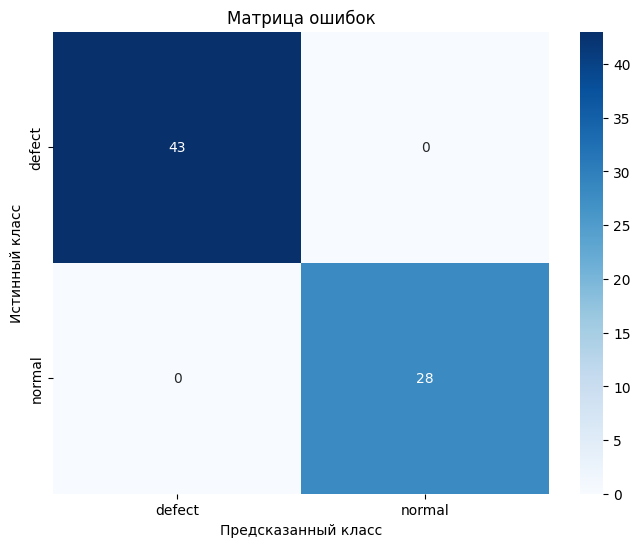

In [21]:
# Построение и визуализация матрицы ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()


--- Визуализация процесса обучения ---


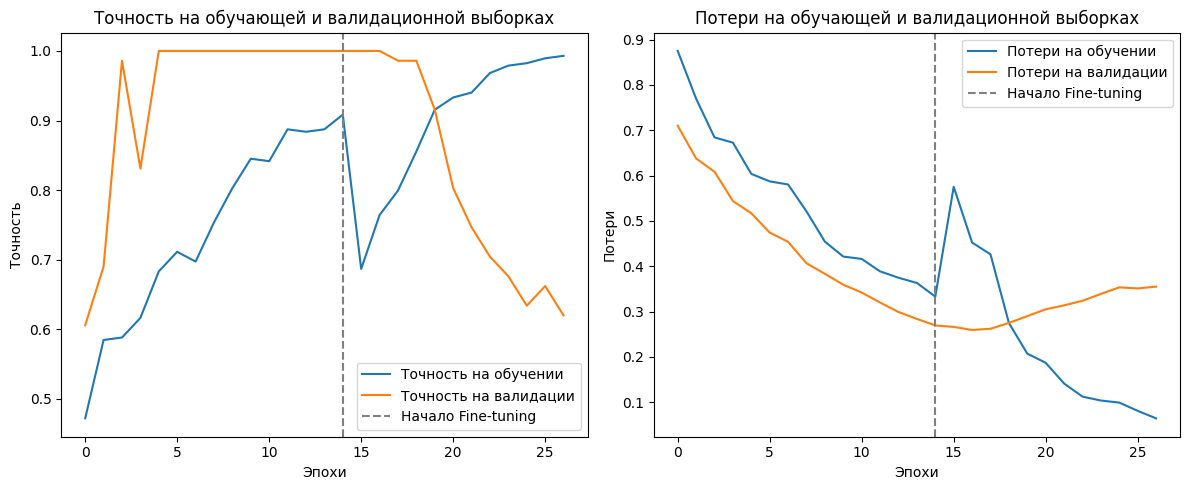

In [22]:
# --- 7. Визуализация процесса обучения (объединенная) ---

print("\n--- Визуализация процесса обучения ---")

# Объединяем истории обучения
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc)) # Общее количество эпох, которое прошло

plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
# Вертикальная линия, разделяющая этапы обучения
plt.axvline(INITIAL_EPOCHS -1 , linestyle='--', color='gray', label='Начало Fine-tuning')
plt.legend(loc='lower right')
plt.title('Точность на обучающей и валидационной выборках')
plt.xlabel('Эпохи')
plt.ylabel('Точность')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.axvline(INITIAL_EPOCHS -1, linestyle='--', color='gray', label='Начало Fine-tuning')
plt.legend(loc='upper right')
plt.title('Потери на обучающей и валидационной выборках')
plt.xlabel('Эпохи')
plt.ylabel('Потери')

plt.tight_layout()
plt.show()


--- Тестирование предсказания на одном изображении ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


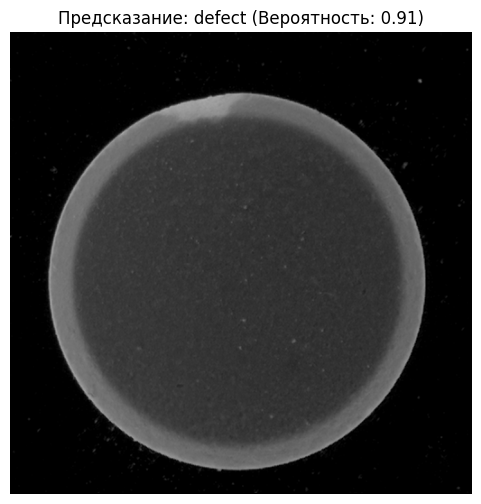


Результат для изображения: /content/Pill-Defects-main/defect/pic.6.1561.0.png
Предсказанный класс: defect
Вероятность: 0.9073
-> Рекомендация ИУС: Отбраковать препарат.

--- Скрипт завершен ---


In [28]:
def predict_pill_defect_transfer(image_path, model, class_indices_map, img_size=(128, 128), display_image=False):
    """
    Загружает изображение, предобрабатывает его для MobileNetV2, делает предсказание
    и опционально отображает изображение с результатом.

    Args:
        image_path (str): Путь к файлу изображения.
        model (tf.keras.Model): Обученная модель Keras.
        class_indices_map (dict): Словарь {'имя_класса': индекс}.
        img_size (tuple): Размер для предобработки.
        display_image (bool): Отображать ли изображение с предсказанием.

    Returns:
        tuple: (predicted_label, probability) или (None, None) в случае ошибки.
    """
    try:
        # Загрузка для предобработки и предсказания
        img_for_processing = cv2.imread(image_path)
        if img_for_processing is None:
            print(f"Ошибка: Не удалось загрузить изображение: {image_path}")
            return None, None

        img_rgb = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, img_size)
        img_array = np.array(img_resized)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)

        # Получение предсказания
        prediction = model.predict(img_preprocessed)
        raw_probability = prediction[0][0]

        # --- Логика определения класса и вероятности ---
        predicted_index = int(raw_probability > 0.5)
        index_to_class_map = {v: k for k, v in class_indices_map.items()}
        defect_index = class_indices_map.get('defect', -1)

        if defect_index == -1:
             print("Предупреждение: класс 'defect' не найден в class_indices_map")
             if raw_probability > 0.5:
                 predicted_index = 1
                 probability = raw_probability
             else:
                 predicted_index = 0
                 probability = 1.0 - raw_probability
             predicted_label = index_to_class_map.get(predicted_index, "Неизвестный класс")
        else:
             if predicted_index == defect_index:
                 predicted_label = 'defect'
                 probability = raw_probability if defect_index == 1 else (1.0 - raw_probability)
             else:
                 predicted_label = 'normal'
                 probability = (1.0 - raw_probability) if defect_index == 1 else raw_probability

        # Отображение изображения, если флаг установлен
        if display_image:
            # Загружаем оригинальное изображение еще раз для отображения (в BGR)
            img_display = cv2.imread(image_path)
            if img_display is not None:
                 # Преобразуем в RGB для matplotlib
                 img_display_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
                 plt.figure(figsize=(6, 6))
                 plt.imshow(img_display_rgb)
                 plt.title(f"Предсказание: {predicted_label} (Вероятность: {probability:.2f})")
                 plt.axis('off') # Отключить оси координат
                 plt.show()
            else:
                 print(f"Предупреждение: Не удалось перезагрузить изображение для отображения: {image_path}")


        return predicted_label, probability

    except Exception as e:
        print(f"Ошибка при обработке или предсказании для изображения {image_path}: {e}")
        return None, None

# --- 9. Пример использования функции предсказания ---

print("\n--- Тестирование предсказания на одном изображении ---")

if os.path.exists(MODEL_SAVE_PATH):
    # Загружаем лучшую модель
    try:
        prediction_model = load_model(MODEL_SAVE_PATH)
    except Exception as e:
        print(f"Ошибка при загрузке модели из {MODEL_SAVE_PATH}: {e}")
        prediction_model = None # Устанавливаем в None, чтобы избежать дальнейших ошибок

    if prediction_model: # Продолжаем, только если модель успешно загружена
        if os.path.exists(EXAMPLE_IMAGE_PATH):
            if 'class_indices' not in locals() or 'IMAGE_SIZE' not in locals():
                 print("Ошибка: Переменные class_indices или IMAGE_SIZE не определены.")
            else:
                 predicted_class, probability = predict_pill_defect_transfer(
                     EXAMPLE_IMAGE_PATH,
                     prediction_model,
                     class_indices,
                     IMAGE_SIZE,
                     display_image=True
                 )

                 # Выводим текстовый результат в консоль (как и раньше)
                 if predicted_class is not None:
                     print(f"\nРезультат для изображения: {EXAMPLE_IMAGE_PATH}")
                     print(f"Предсказанный класс: {predicted_class}")
                     print(f"Вероятность: {probability:.4f}")
                     if predicted_class == 'defect':
                         print("-> Рекомендация ИУС: Отбраковать препарат.")
                     else:
                         print("-> Рекомендация ИУС: Препарат годен.")
                 else:
                     print(f"Не удалось получить предсказание для {EXAMPLE_IMAGE_PATH}")
        else:
            print(f"Ошибка: Тестовое изображение не найдено: {EXAMPLE_IMAGE_PATH}")
            print("Пожалуйста, укажите правильный путь в переменной EXAMPLE_IMAGE_PATH.")
else:
    print(f"Ошибка: Файл модели не найден: {MODEL_SAVE_PATH}")
    print("Пожалуйста, убедитесь, что модель была успешно обучена и сохранена.")

print("\n--- Скрипт завершен ---")